In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import cartopy
import shapely
import scipy.stats
xmin, xmax, ymin, ymax = 90, 180, -50, 15 # 0, 180, -50, 50
def map():
    ax = plt.axes(projection=cartopy.crs.PlateCarree())
    ax.set_extent([xmin, xmax, ymin, ymax], crs=ax.projection)
    ax.coastlines() #ax.stock_img()
    return ax

# Tropical Cyclone modelling
This notebook goes through the dataflow of TCRM, visualising each stage.

IBTRACS is used for its historical archive of storm/cyclone tracks

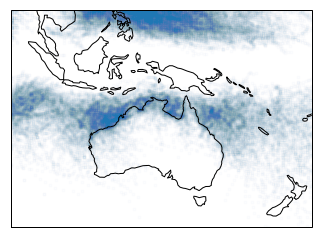

In [60]:
history = pandas.read_csv('input/Allstorms.ibtracs_wmo.v03r10.csv', skiprows=[0,2]) # skip title/units
map().scatter(history.Longitude.values, history.Latitude.values, marker='.', alpha=0.01)

Various data is harvested, including e.g. the locations of storm genesis.

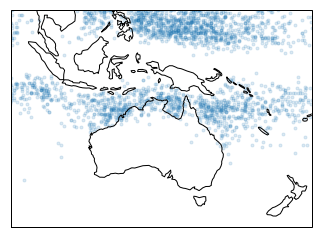

In [62]:
genesis = np.concatenate([[True], history.Serial_Num.values[1:] != history.Serial_Num.values[:-1]])
map().scatter(history.Longitude.values[genesis], history.Latitude.values[genesis], marker='.', alpha=0.15)

The region of interest is enlarged to include the origins of local storms.

In [4]:
tracks = [np.vstack([track.Longitude.values, track.Latitude.values]).T
          for serial, track in history.groupby('Serial_Num') if len(track) > 1]

In [5]:
roi = shapely.geometry.box(117,-30,119,-28)
relevant, origins = zip(*[(t, t[0]) for t in tracks if roi.intersects(shapely.geometry.asMultiPoint(t))])
enlarged = roi.union(shapely.geometry.MultiPoint(origins)).envelope

11

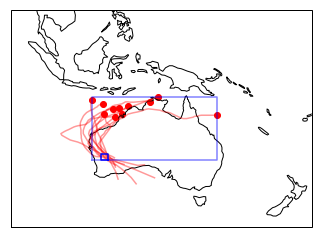

In [63]:
ax = map()
[ax.plot(*t.T, color='r', alpha=0.4) for t in relevant]
ax.plot(*roi.exterior.xy, color='b')
ax.scatter(*zip(*origins), color='r')
ax.plot(*enlarged.exterior.xy, color='b', alpha=0.5)
len(relevant)

Statistics are produced, converting from (vector) discrete events to (raster) probability fields.

In [75]:
kde = scipy.stats.gaussian_kde(np.vstack((history.Longitude.values[genesis], history.Latitude.values[genesis])))
#kde = scipy.stats.gaussian_kde(np.vstack((history.Longitude.values, history.Latitude.values)))

In [76]:
x,y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
raster = kde(np.vstack((x.ravel(), y.ravel()))).reshape(x.shape)

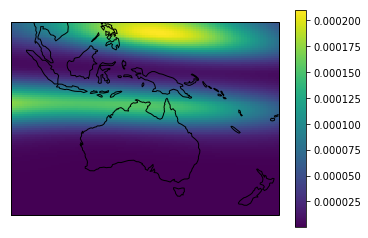

In [77]:
ax = map()
im = ax.imshow(raster.T, extent=[xmin, xmax, ymin, ymax], transform=ax.projection)
plt.colorbar(im)